# SQUID: Shapiro steps
Thomas D. Schanzer  
July 2022

In [331]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline
from scipy.odr import RealData, ODR, Model
from scipy.optimize import curve_fit

matplotlib.rcParams['font.family'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'

## Voltage step size vs. frequency plot

In [297]:
def step_locations(file, smoothing, threshold, interval):
    df = pd.read_csv(file)
    current, voltage = df['0_x'].to_numpy(), df['0_y'].to_numpy()

    # put the current values in ascending order (order is irrelevant)
    idx = np.argsort(current)
    current = current[idx]
    voltage = voltage[idx]
    
    voltage = voltage[(interval[0] < current) & (current < interval[1])]
    current = current[(interval[0] < current) & (current < interval[1])]

    spline = UnivariateSpline(current, voltage, k=3, s=smoothing)
    resistance = spline.derivative()(current)
    
    peaks, properties = find_peaks(
        -resistance, height=-threshold, distance=100, width=20, rel_height=0.1)
    left_idx = np.int64(np.round(properties['left_ips']))
    right_idx = np.int64(np.round(properties['right_ips']))
    widths = current[right_idx] - current[left_idx]
    step_voltage = np.array([
        voltage[l:r].mean() for l, r in zip(left_idx, right_idx)
    ])
    d_voltage = np.array([
        voltage[l:r].std() for l, r in zip(left_idx, right_idx)
    ])

    return current[peaks], widths, step_voltage, d_voltage

def step_height(step_voltage, d_voltage):
    delta_V = np.mean(np.diff(step_voltage))
    d_delta_V = np.mean((d_voltage[:-1] + d_voltage[1:])/2)
    return delta_V, d_delta_V

def linear(x, m, b):
    return m*x + b

In [309]:
smoothing = np.array([
    1.15, 1.2, 1.38, 1.23, 1.14, 1.03, 1.03, 1.18, 1.2, 1.05, 1.0, 0.99,
])*1e4

delta_V, d_delta_V = np.zeros(12), np.zeros(12)
for i in range(12):
    _, _, step_voltage, d_voltage = step_locations(
        f'../data/21072022/shapiro_21072022_{i+1}.csv',
        smoothing[i], 0.6, (-125, 125),
    )
    delta_V[i], d_delta_V[i] = step_height(step_voltage, d_voltage)
    
frequency = np.array([
    20., 19.965, 19.92, 19.814, 19., 18.2, 17.2,
    16.15, 15.2, 14.19, 12.963, 11.590,
])

params, cov = curve_fit(
    linear, frequency*1e9, delta_V*1e-6,
    sigma=d_delta_V*1e-6, absolute_sigma=True
)
d_params = np.sqrt(np.diag(cov))
fit = linear(frequency*1e9, *params)/1e-6
residuals = delta_V - fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((delta_V - delta_V.mean())**2)
r_squared = 1 - ss_res/ss_tot

In [329]:
def add_number(ax, text):
    ax.text(
        0.05, 0.87, text, transform=ax.transAxes, fontsize=16,
        fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
    )

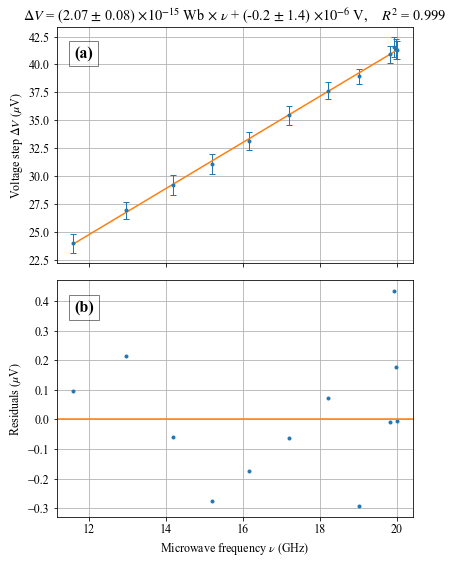

In [339]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8), sharex=True)
ax1.errorbar(
    frequency, delta_V, yerr=d_delta_V,
    marker='.', linestyle='', elinewidth=1, capsize=3)
ax1.plot(frequency, fit)
ax1.grid()
title = (
    '$\\Delta V$ ='
    ' ({:.2f} $\\pm$ {:.2f}) $\\times 10^{{-15}}$ Wb $\\times$ $\\nu$'
    ' + ({:.1f} $\\pm$ {:.1f}) $\\times 10^{{-6}}$ V,'
    '    $R^2$ = {:.3f}'
).format(params[0]*1e15, d_params[0]*1e15, params[1]*1e6, d_params[1]*1e6, r_squared)
ax1.set(ylabel='Voltage step $\\Delta V$ ($\mu$V)', title=title)
add_number(ax1, '(a)')

ax2.plot(frequency, delta_V - fit, '.')
ax2.axhline(0, color='tab:orange')
ax2.grid()
ax2.set(xlabel='Microwave frequency $\\nu$ (GHz)', ylabel='Residuals ($\mu$V)')
add_number(ax2, '(b)')

fig.tight_layout()
fig.savefig('../figures/step_vs_freq.pdf', bbox_inches='tight')

In [333]:
from scipy.constants import physical_constants

physical_constants['magn. flux quantum']

(2.067833848e-15, 'Wb', 0.0)

## Plot to illustrate method

In [348]:
df = pd.read_csv('../data/09062022/shapiroSteps2.csv')
current, voltage = df['0_x'].to_numpy(), df['0_y'].to_numpy()

# put the current values in ascending order (order is irrelevant)
idx = np.argsort(current)
current = current[idx]
voltage = voltage[idx]

spline = UnivariateSpline(current, voltage, k=3, s=900)

resistance = spline(current, nu=1)
peaks, properties = find_peaks(
    -resistance, height=-0.2, distance=100, width=20, rel_height=0.1)
left_idx = np.int64(np.round(properties['left_ips']))
right_idx = np.int64(np.round(properties['right_ips']))
widths = current[right_idx] - current[left_idx]
step_voltage = np.array([
    voltage[l:r].mean() for l, r in zip(left_idx, right_idx)
])
d_voltage = np.array([
    voltage[l:r].std() for l, r in zip(left_idx, right_idx)
])

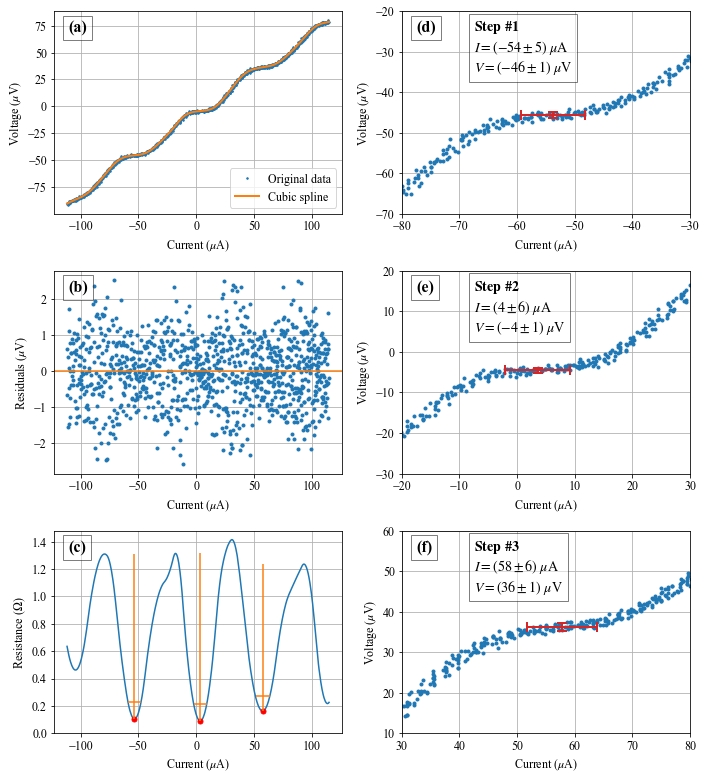

In [349]:
fig, axes = plt.subplots(3, 2, figsize=(10,11))

axes[0,0].plot(current, voltage, '.', markersize=3, label='Original data')
axes[0,0].plot(current, spline(current), linewidth=2, label='Cubic spline')
axes[0,0].grid()
axes[0,0].set(xlabel='Current ($\mu$A)', ylabel='Voltage ($\mu$V)')
axes[0,0].text(
    0.05, 0.9, '(a)', transform=axes[0,0].transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)
axes[0,0].legend(loc='lower right')

axes[1,0].plot(current, voltage - spline(current), '.')
axes[1,0].axhline(0, color='tab:orange')
axes[1,0].grid()
axes[1,0].set(xlabel='Current ($\mu$A)', ylabel='Residuals ($\mu$V)')
axes[1,0].text(
    0.05, 0.9, '(b)', transform=axes[1,0].transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)

axes[2,0].plot(current, resistance)
axes[2,0].plot(current[peaks], resistance[peaks], 'r.', markersize=10)
axes[2,0].vlines(
    x=current[peaks], ymin=resistance[peaks],
    ymax=resistance[peaks] + properties['prominences'],
    color='tab:orange',
)
axes[2,0].hlines(
    y=-properties['width_heights'],
    xmin=current[left_idx], xmax=current[right_idx], color='tab:orange',
)
axes[2,0].set(xlabel='Current ($\mu$A)', ylabel='Resistance ($\Omega$)')
axes[2,0].grid()
axes[2,0].set_ylim(bottom=0)
axes[2,0].text(
    0.05, 0.9, '(c)', transform=axes[2,0].transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)

for i, ax in enumerate(axes[:,1]):
    ax.plot(current, voltage, '.')
    ax.errorbar(
        current[peaks], step_voltage, xerr=widths/2, yerr=d_voltage,
        marker='', color='tab:red', linestyle='', elinewidth=2, capsize=5,
        markersize=10, capthick=2
    )
    ax.grid()
    text = (
        '$\\mathbf{{Step~\#{:d}}}$\n'
        '$I = ({:.0f} \\pm {:.0f})$ $\mu$A\n'
        '$V = ({:.0f} \\pm {:.0f})$ $\mu$V'
    ).format(i+1, current[peaks[i]], widths[i]/2,
             step_voltage[i], d_voltage[i])
    ax.text(
        0.25, 0.7, text, transform=ax.transAxes, fontsize=14,
        bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
    )
    ax.set(xlabel='Current ($\mu$A)', ylabel='Voltage ($\mu$V)')
    
axes[0,1].set_xlim(-80, -30)
axes[0,1].set_ylim(-70, -20)
axes[1,1].set_xlim(-20, 30)
axes[1,1].set_ylim(-30, 20)
axes[2,1].set_xlim(30, 80)
axes[2,1].set_ylim(10, 60)

axes[0,1].text(
    0.05, 0.9, '(d)', transform=axes[0,1].transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)
axes[1,1].text(
    0.05, 0.9, '(e)', transform=axes[1,1].transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)
axes[2,1].text(
    0.05, 0.9, '(f)', transform=axes[2,1].transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)

fig.tight_layout()
fig.savefig('../figures/shapiro_steps.pdf', bbox_inches='tight')

In [350]:
phi0 = (step_voltage[2] - step_voltage[0])*1e-6/2/19.935e9
d_phi0 = (d_voltage[2] + d_voltage[0])/2*1e-6/19.935e9
phi0*1e15, d_phi0*1e15

(2.053677679601562, 0.03962623454175739)

In [351]:
physical_constants['magn. flux quantum']

(2.067833848e-15, 'Wb', 0.0)